### Abstract

This notebook is intended to showcase how to use the MNL (Multinomial Logistic Regression) model to predict the booking probability for each option within a session.

One can find the sample training and testing data under the `data` folder.

In [192]:
# import the model and all the auxiliary functions
from MNL import *
from MNL_plus import *
from Mint import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import numpy as np

import pprint 
pp = pprint.PrettyPrinter(indent=4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 100

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gazccon3 because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# To save output into txt file
from contextlib import redirect_stdout

In [251]:
TRAIN_CONFIG = {
    #'MNL_features': MNL_features,
    
    # when absent, by default, use all the features within the training data
    #'alter_features': MNL_features,
    #'session_features'
    
    # options: BinaryCrossEntropy, MaxLogLikelihood
    #'loss':  'MaxLogLikelihood',
    'loss':  'MaxLogLikelihood',
    
    'expand': False,
    
    'optimizer': 'Adam',  # options:  Adam, RMSprop, SGD, LBFGS.
    # Adam would converge much faster
    # LBFGS is a very memory intensive optimizer (it requires additional param_bytes * (history_size + 1) bytes).
    # If it doesn’t fit in memory try reducing the history size, or use a different algorithm.
    # By default, history_size == 100
    'learning_rate': 0.1, # Applicable to Adam, SGD, and LBFGS
    # The learning_rate parameter seems essential to LBFGS, which converges in two epochs.
    #  So far, learning_rate == 0.1 seems to be ok for LBFGS
    
    #'momentum': 0.9,  # applicable to SGD, RMSprop
    'momentum': 0.01,  # applicable to SGD, RMSprop
    
    # The resulting model seems to be more balanced, i.e. no extreme large/small weights,
    #  although one might not have the most ideal performance, i.e. high top_5_rank etc.
    'weight_decay': 0, # Applicable to Adam, RMSprop and SGD
    

    # indicates the number of sessions included in each batch
    'batch_size': 500,
    
    #maximum number of epochs
    'epochs': 20,
    
    #tolerance for early stopping
    'early_stop_min_delta': 1e-4,
    'patience': 5,
    
    #if able to use GPU (unfortunately I am not able to do this)
    'gpu': False,  # luckily, running on GPU is faster than CPU in this case.
    
    # level of logging, 0: no log,  1: print epoch related logs;  2: print session related logs
    'verbose': 1,
    
    # Adding the regularization degredates the performance of model
    #   which might suggests that the model is still underfitting, not overfitting.
    'l1_loss_weight': 0,  # e.g. 0.001 the regularization that would marginalize the weights
    'l2_loss_weight': 0,
    
    # flag indicates whether to save gradients during the training
    'save_gradients': False

}


Num features: 17
All features: ['deptime_inbound_cos2p', 'deptime_inbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'price_elasticity', 'reco_contains_CX', 'reco_contains_MH', 'reco_contains_OD', 'reco_contains_PG', 'reco_contains_SQ', 'reco_contains_TG', 'reco_contains_VN', 'rescaled_reco_eft']
Alternative Features: []
Session Features: []
Loaded but dropped features: []
Group IDs: []
Batch_id: 0/4: Size=23245
Batch_id: 1/4: Size=25750
Batch_id: 2/4: Size=26953
Batch_id: 3/4: Size=24652
epoch: 0  loss: -11.908535625091986 best_loss: 1000000000000000.0
Batch_id: 0/4: Size=23245
Batch_id: 1/4: Size=25750
Batch_id: 2/4: Size=26953
Batch_id: 3/4: Size=24652
epoch: 1  loss: -12.589252489894552 best_loss: -11.908535625091986
Batch_id: 0/4: Size=23245
Batch_id: 1/4: Size=25750
Batch_id: 2/4: Size=26953
Batch_id: 3/4: Size=24652
epoch: 2  loss: -12.892814426864762 best_loss:

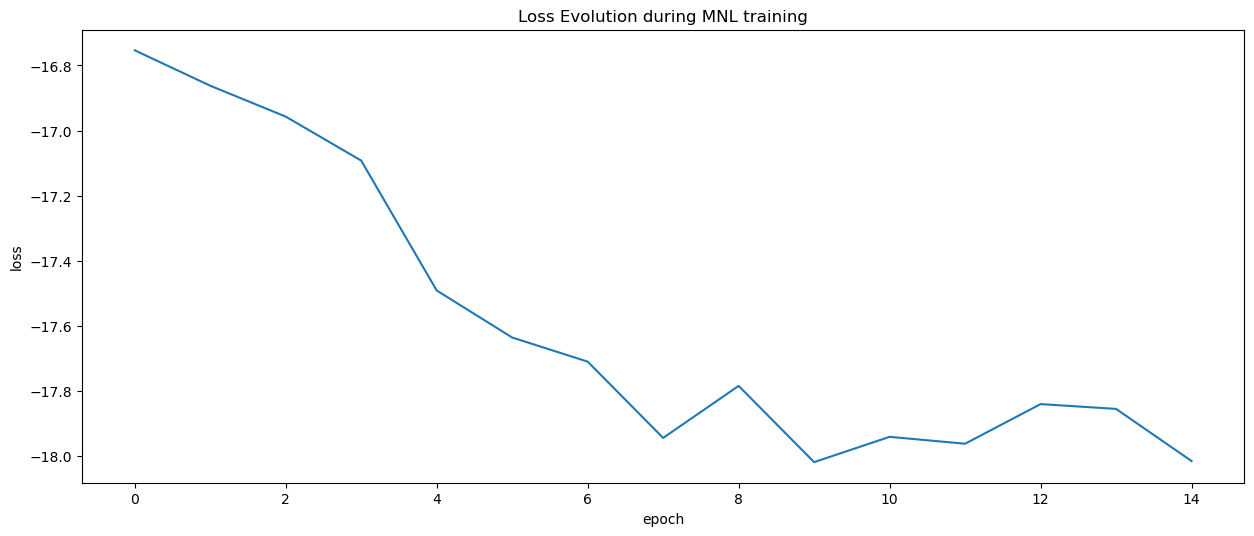

In [252]:
# set random seed for reproduceability
np.random.seed(17)
torch.manual_seed(17)

df_train = pd.read_csv('data/train_SINBKK_RT_B.csv')

# Create a brand-new model
from contextlib import redirect_stdout

model_tuple, loss_list = run_training(df_training=df_train, train_config=TRAIN_CONFIG)

# Continue training on the existing model
model_tuple, loss_list = run_training(df_training=df_train, train_config=TRAIN_CONFIG, model_tuple=model_tuple)


# unzip the tuple
(model, loss, optimizer) = model_tuple


# plot the evolution of loss
plot_loss(loss_list)

### Model Stats

In this section, we calculate some statistics in the train data

In [253]:
# Test the model with the testing data
# Calculate the probability and the trank of the chosen alternative
train_stats = validate(model, df_train, TRAIN_CONFIG)
train_stats.head()

Num of testing sessions: 1947
Batch_id: 0/4: Size=26054
Batch_id: 1/4: Size=25372
Batch_id: 2/4: Size=25891
Batch_id: 3/4: Size=23283


,session_id,session_size,num_chosen_choices,rank_of_chosen_one,prob_of_chosen_one,max_prob,second_highest_prob,third_highest_prob
0,1702200,18,1,2.0,2.075321e-01,0.789296,0.789296,0.789296
1,1704127,10,1,2.0,2.029650e-01,0.771926,0.771926,0.771926
2,17012029,52,1,4.0,7.824389e-03,0.932872,0.932872,0.932872
3,17020644,25,1,20.0,1.084281e-10,0.744116,0.744116,0.744116
4,17020739,56,1,8.0,1.282415e-08,0.849749,0.849749,0.849749


Summarize the testing results into a list of KPIs, such as:

- *mean_probability*: the average probability of the predicted alternative among all sessions


- *top_5_rank_quantile*: the percentile of sessions where the probability of the predicted alternative is among the top 5.


- *AIC*: Akaike Information Criterion, which offers an estimate of the relative information lost when a given model is used to represent the process that generated the data.

In [254]:
summarize_KPIs(train_stats, len(TRAIN_CONFIG['MNL_features']))

{'session_num': 1947,
 'mean_session_size': 51.66923472008218,
 'top_1_rank_quantile': 18.746789933230612,
 'top_5_rank_quantile': 52.028762198253716,
 'top_10_rank_quantile': 70.67282999486389,
 'mean_rank_ratio': 0.18604141300591448,
 'median_rank_ratio': 0.1111111111111111,
 'mean_rank': 8.355675398048279,
 'median_rank': 5.0,
 'mean_probability': 0.18477954478914158,
 'median_probability': 0.0003556197176559163,
 'mean_probability_diff': -0.68367902673967,
 'median_probability_diff': -0.9053598084989057,
 'log_likelihood': -18247.11662328771,
 'mean_log_likelihood': -9.371914033532466,
 'AIC': 36528.23324657542}

## Implementation with expand option 

In this section, I show how to use the expand option. You will see that there are three datasets this time (take a look at the dummy do file in the data folder to see how they are constructed)

In [4]:
session_id=['session_id']
alter_id=['alter_id']
alter_features=
session_features=
choice_groups=
session_alter_features=

In [5]:
#define choice-alternative function
def session_alter(data):
    return data['reco_contains_mh']*data['deptime_outbound_sin4p']+data['deptime_outbound_cos4p']

In [179]:
from nmlogit_config	 import *
config['session_id']='session_id'
config['alter_id']='alter_id'
config['alter_features']=['reco_contains_mh', 'reco_contains_tg', 'reco_contains_pg', 'reco_contains_sq', 'reco_contains_vn', 'reco_contains_cx', 'reco_contains_od']
config['session_features']=['deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_inbound_cos2p', 'deptime_inbound_cos4p']
config['choice_groups']=['group','group2']
config['session_alter_features']=[]
config['extra_choice_features']=[]
config['session_alter_fn']=[]
config['drop_vars']=[]
config['batch_size']=7788
config['loss']='BinaryCrossEntropy'

In [180]:
model_tuple, loss_list = run_training(df_training=choices, train_config=config, alter_data=alter_data, session_data=session_data)
(model, loss, optimizer) = model_tuple

Num features: 15
All features: ['reco_contains_mh', 'reco_contains_tg', 'reco_contains_pg', 'reco_contains_sq', 'reco_contains_vn', 'reco_contains_cx', 'reco_contains_od', 'deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_inbound_cos2p', 'deptime_inbound_cos4p']
Alternative Features: ['reco_contains_mh', 'reco_contains_tg', 'reco_contains_pg', 'reco_contains_sq', 'reco_contains_vn', 'reco_contains_cx', 'reco_contains_od']
Session Features: ['deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_inbound_cos2p', 'deptime_inbound_cos4p']
Loaded but dropped features: []
Group IDs: ['group', 'group2']
Batch_id: 0/1: Size=7788 expanded to 486750
epoch: 0  loss: 0.07681939907818736 best_loss: 1000000000000000.0
Batch_id: 0/1: Size=7788 expanded to 486750
epoch: 1  loss: 0.076

Get statistics

In [202]:
choices = pd.read_csv('data/train_SINBKK_RT_B_choices.csv')[['session_id','alter_id','choice','group','group2']]

In [205]:
test_results = test_model(model=model, df_testing=choices, train_config=config, alter_data=alter_data, session_data=session_data)
test_results.head()

Num of testing sessions: 7788
Batch_id: 0/1: Size=7788 expanded to 486750


,session_id,choice,group,group2,alter_id,reco_contains_mh,reco_contains_tg,reco_contains_pg,reco_contains_sq,reco_contains_vn,...,reco_contains_od,deptime_outbound_sin2p,deptime_outbound_sin4p,deptime_outbound_cos2p,deptime_outbound_cos4p,deptime_inbound_sin2p,deptime_inbound_sin4p,deptime_inbound_cos2p,deptime_inbound_cos4p,pred_value
0,3404400,1,1,hola,40,0.0,0.611111,0,0.333333,0,...,0,0.94693,-0.608761,-0.321439,-0.793353,-0.819152,0.939693,-0.573576,-0.34202,0.016445
1,3404400,0,1,hola,55,0.0,0.366667,0,0.633333,0,...,0,0.94693,-0.608761,-0.321439,-0.793353,-0.819152,0.939693,-0.573576,-0.34202,0.017352
2,3404400,0,1,hola,38,0.0,0.463415,0,0.512195,0,...,0,0.94693,-0.608761,-0.321439,-0.793353,-0.819152,0.939693,-0.573576,-0.34202,0.016991
3,3404400,0,1,hola,54,0.0,0.545455,0,0.393939,0,...,0,0.94693,-0.608761,-0.321439,-0.793353,-0.819152,0.939693,-0.573576,-0.34202,0.016697
4,3404400,0,1,hola,57,0.0,0.513514,0,0.459459,0,...,0,0.94693,-0.608761,-0.321439,-0.793353,-0.819152,0.939693,-0.573576,-0.34202,0.016792


In [198]:
choices = pd.read_csv('data/train_SINBKK_RT_B_choices.csv')[['session_id','alter_id','choice','group','group2']]
# Test the model with the testing data
# Calculate the probability and the trank of the chosen alternative
train_stats = validate(model=model, df_testing=choices, train_config=config, alter_data=alter_data, session_data=session_data)
train_stats.head()

Num of testing sessions: 7788
Batch_id: 0/1: Size=7788 expanded to 486750


,session_id,session_size,num_chosen_choices,rank_of_chosen_one,prob_of_chosen_one,max_prob,second_highest_prob,third_highest_prob
0,3404400,60,1,44.0,0.016445,0.017587,0.017587,0.017587
1,3408254,60,1,3.0,0.017352,0.017587,0.017587,0.017587
2,5106600,60,1,14.0,0.016975,0.018079,0.018079,0.018079
3,5112381,60,1,39.5,0.016489,0.018079,0.018079,0.018079
4,13617600,120,1,3.0,0.008928,0.009356,0.009356,0.009356


Summarize the testing results into a list of KPIs, such as:

- *mean_probability*: the average probability of the predicted alternative among all sessions


- *top_5_rank_quantile*: the percentile of sessions where the probability of the predicted alternative is among the top 5.


- *AIC*: Akaike Information Criterion, which offers an estimate of the relative information lost when a given model is used to represent the process that generated the data.

In [200]:
summarize_KPIs(train_stats, len(config['MNL_features']))

{'session_num': 7788,
 'mean_session_size': 62.5,
 'top_1_rank_quantile': 3.7236774524910117,
 'top_5_rank_quantile': 17.347200821777093,
 'top_10_rank_quantile': 35.451977401129945,
 'mean_rank_ratio': 0.5105991054613936,
 'median_rank_ratio': 0.5,
 'mean_rank': 31.094568567026194,
 'median_rank': 24.0,
 'mean_probability': 0.035422682352992424,
 'median_probability': 0.01668889549289732,
 'mean_probability_diff': -0.0012714105067392748,
 'median_probability_diff': -0.001154786635640585,
 'log_likelihood': -29744.74764745806,
 'mean_log_likelihood': -3.8193050394784365,
 'AIC': 59519.49529491612}

In [279]:
from scipy.stats import norm
from operator import truediv

b=model.get_params()
gradient=model.get_params().grad
hessian=torch.mm(torch.t(gradient),gradient)
se = torch.sqrt(torch.diagonal(hessian))
t=torch.div(b,se)

In [280]:
b=b.tolist()
se=se.tolist()
gradient=gradient.tolist()
hessian=hessian.tolist()
t=t.tolist()

In [281]:
p=1-norm.cdf(t)

In [286]:
np.shape(hessian)

(17, 17)